# Analyze landfast ice

## Fast ice edge (Sina)

In [2]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
# %matplotlib notebook

In [14]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]       

CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100

In [4]:
# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

In [5]:
years_unique

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

### Mapping

Find longitude of sina point for each latitude

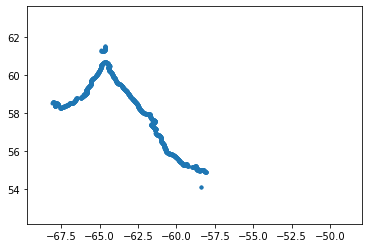

In [9]:
# CS = plt.contour(lon, lat, CT[-35,:,:], levels=[99.9])
CS = plt.contour(lon, lat, CT[131,:,:], levels=[99.9])
sina = CS.allsegs
sina = np.concatenate(np.concatenate(sina, axis=0))
xarr = sina[:,0]
yarr = sina[:,1]
plt.plot(xarr,yarr,'.')

transform2 = rot.transform_points(rot,xarr,yarr)
xarr_n = transform2[...,0]
yarr_n = transform2[...,1]

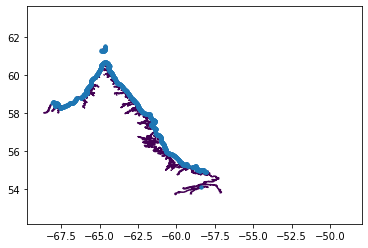

In [15]:
# Get land values
CS = plt.contour(lon, lat, land, levels=[0])
sina = CS.allsegs
sina = np.concatenate(np.concatenate(sina, axis=0))
landx = sina[:,0]
landy = sina[:,1]
plt.plot(xarr,yarr,'.')

transform2 = rot.transform_points(rot,landx,landy)
x_land = transform2[...,0]
y_land = transform2[...,1]

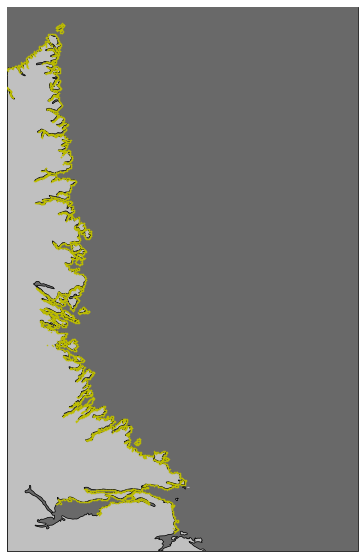

In [16]:
#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgrey')

#Declare the lat and lon boundaries for the map and data
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[1] = np.min(lon) # West
domain[2] = np.max(lat) # North
domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
# domain = [55, -61.30979545701268, 59, -61]

aoi_map = [domain[0], domain[2], domain[1], domain[3]]
# Rotation for vertical coast
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Plot results
transform = rot.transform_points(rot,lon,lat)
x_n = transform[...,0]
y_n = transform[...,1]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection=rot)
ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
# im = plt.pcolormesh(x_n,y_n,CT[131,:,:],transform=ccrs.PlateCarree(),zorder=4)  
# plt.contour(x_n,y_n,CT[-25,:,:],levels=100,transform=ccrs.PlateCarree(),zorder=4)
# plt.contour(x_n,y_n,CT[-35,:,:]==100,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(xarr_n[100:2000],yarr_n[100:2000],'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
plt.plot(x_land,y_land,'y.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(xarr_n,yarr_n,'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)

# for i in range(len(x)):
#     plt.plot(x[i],y[i],'.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)


# plt.pcolor(x_n,y_n,land,transform=ccrs.PlateCarree(),zorder=4)

Issues: land contour is not uniform. Plus there are islands. Difficult to find distance between land and sina. Maybe try plotting distance between sina of a relative year and all other years?

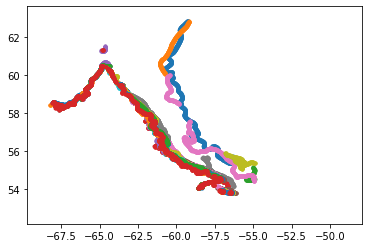

In [17]:
cnt=0
x=[]
y=[]
for yr in years_unique:
    which = (years == yr) * (np.array(months) == 3)

    if np.sum(which) >= 1:
        tt = np.where(which)[0][0]
#         plt.contour(x_n, y_n, CT[tt,:,:], levels=[99.9])
        CS = plt.contour(lon, lat, CT[tt,:,:], levels=[99.9])
        sina = CS.allsegs
        sina = np.concatenate(np.concatenate(sina, axis=0))
        xarr = sina[:,0]
        yarr = sina[:,1]
        plt.plot(xarr,yarr,'.')

        transform = rot.transform_points(rot,xarr,yarr)
        x.append(transform[...,0])
        y.append(transform[...,1])
    cnt += 1

In [18]:
# Filter out weird contours

X=[]
Y=[]
years_sina=[]
for i in range(len(x)):
    if np.nanmean(x[i]) < -60.5: # if the sina is the true sina (average lat is not greater than 60.5)
        X.append(x[i])
        Y.append(y[i])
        years_sina.append(years_unique[i])
        

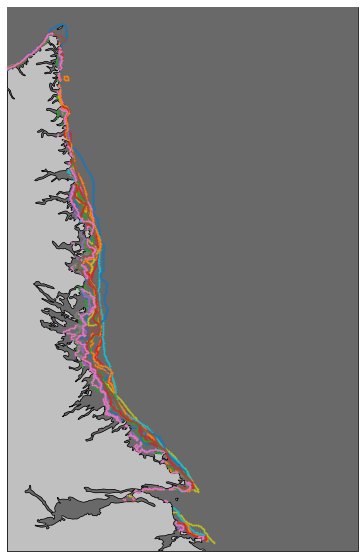

In [19]:
#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgrey')

#Declare the lat and lon boundaries for the map and data
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[1] = np.min(lon) # West
domain[2] = np.max(lat) # North
domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
# domain = [55, -61.30979545701268, 59, -61]

aoi_map = [domain[0], domain[2], domain[1], domain[3]]
# Rotation for vertical coast
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Plot results
transform = rot.transform_points(rot,lon,lat)
x_n = transform[...,0]
y_n = transform[...,1]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection=rot)
ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
# im = plt.pcolormesh(x_n,y_n,CT[131,:,:],transform=ccrs.PlateCarree(),zorder=4)  
# plt.contour(x_n,y_n,CT[-25,:,:],levels=100,transform=ccrs.PlateCarree(),zorder=4)
# plt.contour(x_n,y_n,CT[-35,:,:]==100,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(xarr_n[100:2000],yarr_n[100:2000],'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(landx[2000:3000],landy[2000:3000],'y.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(xarr_n,yarr_n,'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)

for i in range(len(X)):
    plt.plot(X[i],Y[i],'.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)


# plt.pcolor(x_n,y_n,land,transform=ccrs.PlateCarree(),zorder=4)

Try: Define new coastline (take most Eastward lat point on Mainland) for each defined section of the current coastline, create new latitudinal grid. Then, interpolate landfast ice edge coordinates on new latitude grid.

***

Try Xianmin's suggestion: use NASA's dist2coast data: https://pae-paha.pacioos.hawaii.edu/thredds/dist2coast.html?dataset=dist2coast_1deg_ocean

In [462]:
nc = Dataset('dist2coast_1deg_ocean3.nc')
londist = nc.variables['lon'][:]
latdist = nc.variables['lat'][:]
dist = nc.variables['dist'][:]

In [463]:
llond, llatd = np.meshgrid(londist,latdist)

In [430]:
np.shape(llond)

(701, 1001)

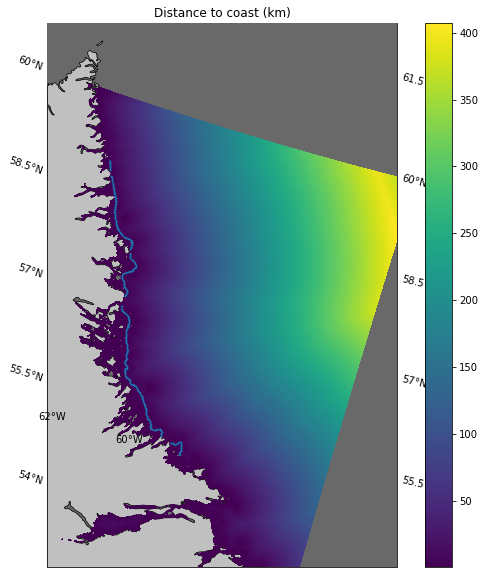

In [613]:
#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgrey')

#Declare the lat and lon boundaries for the map and data
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[1] = np.min(lon) # West
domain[2] = np.max(lat) # North
domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
# domain = [55, -61.30979545701268, 59, -61]

aoi_map = [domain[0], domain[2], domain[1], domain[3]]
# Rotation for vertical coast
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Plot results
transform = rot.transform_points(rot,llond,llatd)
x_n = transform[...,0]
y_n = transform[...,1]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection=rot)
ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
# cartopy.mpl.gridliner.Gridliner(ax, rot, draw_labels=True)
ax.gridlines(draw_labels=True)
# im = plt.pcolormesh(x_n,y_n,CT[131,:,:],transform=ccrs.PlateCarree(),zorder=4)  
# plt.contour(x_n,y_n,CT[-25,:,:],levels=100,transform=ccrs.PlateCarree(),zorder=4)
# plt.contour(x_n,y_n,CT[-35,:,:]==100,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(xarr_n[100:2000],yarr_n[100:2000],'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(landx[2000:3000],landy[2000:3000],'y.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
im = plt.pcolormesh(x_n,y_n,dist,transform=ccrs.PlateCarree(),zorder=4)
plt.title('Distance to coast (km)')
plt.colorbar()
# plt.pcolor(x_n,y_n,land,transform=ccrs.PlateCarree(),zorder=4)
# for i in range(len(X)):
#     plt.plot(X[i],Y[i],'.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
plt.plot(Xred[0],Yred[0],'.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)


Get distance from coast by matching coordinates of sina to coordinates of distance array

In [21]:
# Focus in on one area (reduce domain) 
Yred=[]
Xred=[]
for i in range(len(Y)):
    inds = (np.where((Y[i] > 55) & (Y[i] < 59)) and (X[i] > -64))
    Yred.append(Y[i][inds])
    Xred.append(X[i][inds])

In [22]:
def find_nearest(londistarr,latdistarr, lon, lat): 
    idx = (np.abs(londistarr - lon)).argmin() 
    idy = (np.abs(latdistarr - lat)).argmin() 
    return idx, idy

In [23]:
# D=np.zeros(np.shape(Xred))
# lonD=np.zeros(np.shape(Xred))
# latD=np.zeros(np.shape(Xred))

# D = np.nan*np.ones(Xred.shape)
D = np.copy(Xred)*0
lonred = np.copy(Xred)*0
latred = np.copy(Yred)*0

for i in range(len(Xred)):
#     D = np.nan*np.ones(Xred[i].shape)
    for j in range(len(Xred[i])):
        idx,idy = find_nearest(londist,latdist,Xred[i][j],Yred[i][j])
        D[i][j] = dist[idx,idy]
        lonred[i][j] = londist[idx]
        latred[i][j] = latdist[idy]

NameError: name 'londist' is not defined

In [ ]:
llonred, llatred = np.meshgrid(lonred[0],latred[0])


In [24]:
#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgrey')

#Declare the lat and lon boundaries for the map and data
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[1] = np.min(lon) # West
domain[2] = np.max(lat) # North
domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
# domain = [55, -61.30979545701268, 59, -61]

aoi_map = [domain[0], domain[2], domain[1], domain[3]]
# Rotation for vertical coast
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Plot results
transform = rot.transform_points(rot,llonred,llatred)
x_n = transform[...,0]
y_n = transform[...,1]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection=rot)
ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
ax.gridlines(draw_labels=True)
# im = plt.pcolormesh(x_n,y_n,CT[131,:,:],transform=ccrs.PlateCarree(),zorder=4)  
# plt.contour(x_n,y_n,CT[-25,:,:],levels=100,transform=ccrs.PlateCarree(),zorder=4)
# plt.contour(x_n,y_n,CT[-35,:,:]==100,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(xarr_n[100:2000],yarr_n[100:2000],'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(landx[2000:3000],landy[2000:3000],'y.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# im = plt.plot(lonred[5],latred[5],'r.',transform=ccrs.PlateCarree(),zorder=4)

im = plt.plot(Xred[5],Yred[5],'r-',transform=ccrs.PlateCarree(),zorder=4)

# plt.pcolor(x_n,y_n,land,transform=ccrs.PlateCarree(),zorder=4)
# for i in range(len(X)):
#     plt.plot(X[i],Y[i],'.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(Xred[0],Yred[0],'b.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)


NameError: name 'llonred' is not defined

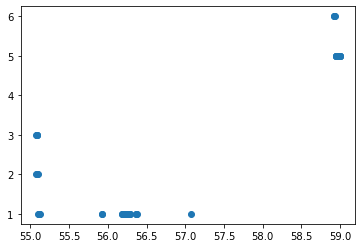

In [611]:
# Distance over latitude
plt.figure()
plt.plot(latred[5], D[5],'o')

NASA data resolution is probably too coarse. Try now to define own coastline. Group coastline coordinates into groups of size N, find the most Eastward point of that group and add it to the new coastline array. 

***

In [49]:
coastx=[]
coasty=[]
n = 30 # group size

for i in range(0, len(landx), n):
    most_east_idx = np.where(landx == np.nanmax(landx[i:i + n]))
    coastx.append(landx[most_east_idx[0][0]])
    coasty.append(landy[most_east_idx[0][0]])

coastx = np.array(coastx)
coasty = np.array(coasty)

# Remove points in HB
coasty = coasty[coastx>-64]
coastx = coastx[coastx>-64]

# # Sort by decreasing latitude
# coasty,coastx = (np.array(t) for t in zip(*sorted(zip(coasty,coastx))))

# # Interpolate coastline
# f = interp1d(coasty,coastx,kind='nearest')

# # filter out weird points
# coastx = np.concatenate((coastx[12:20],coastx[22:-1]))
# coasty = np.concatenate((coasty[12:20],coasty[22:-1]))


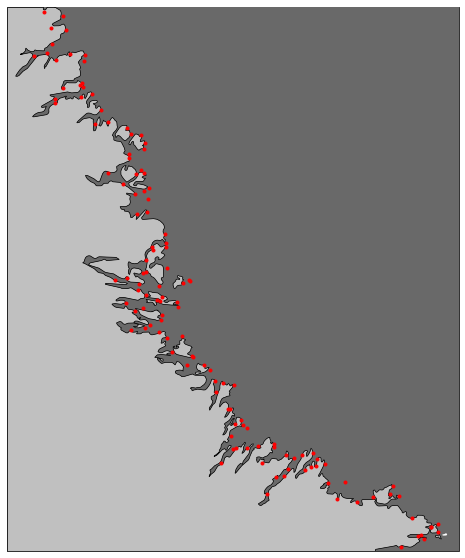

In [52]:
# from scalebar import scale_bar

transform = rot.transform_points(rot,coastx,coasty)
x_Land = transform[...,0]
y_Land = transform[...,1]

domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[1] = np.min(lon) # West
domain[2] = np.max(lat) # North
domain[3] = np.max(lon) # East
domain = list(np.array(domain) + np.array([+2.2, +6, -4.8, -9]))
aoi_map = [domain[0], domain[2], domain[1], domain[3]]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
# ax.gridlines(draw_labels=True)

# Plot coastline
im = plt.plot(coastx,coasty,'r.',transform=ccrs.PlateCarree(),zorder=4)

              
# Plot 
colormap = plt.cm.jet 
normalize = matplotlib.colors.Normalize(vmin=0, vmax=100)
# plt.scatter(x, y, c=z, s=5, cmap=colormap, norm=normalize, marker='*')
# for i in range(len(Xred)):
#     plt.scatter(Xred[i],Yred[i],c=abs(d_km[i]),cmap=colormap,norm=normalize,transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(coastx,coasty,'r.',transform=ccrs.PlateCarree(),zorder=4)
# plt.colorbar()
# scale_bar(ax, (0.65, 0.4), 1)

In [33]:
# Focus in on one area (reduce domain) 
Yred=[]
Xred=[]
for i in range(len(Y)):
    inds = (np.where( (Y[i] > np.min(coasty)) & (Y[i] < np.max(coasty)) & (X[i] > -64)))
    Yred.append(Y[i][inds])
    Xred.append(X[i][inds])

In [34]:
# Convert to distance from degree. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

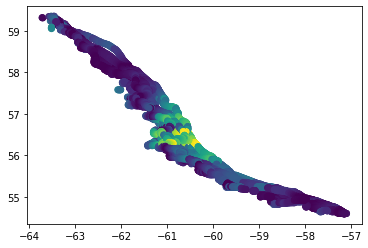

In [42]:
d_km = []
for i in range(len(Xred)):
#     Y_km, X_km = deg2km(Yred[i], Xred[i])
#     coasty_km, coastx_km = deg2km(Yred[i], f(Yred[i]))
#     d_km.append(X_km-coastx_km)
    u_km, v_km = deg2km(Yred[i], f(Yred[i]) - Xred[i])
    d_km.append(u_km)
    plt.scatter(Xred[i],Yred[i],c=d_km[i]) 

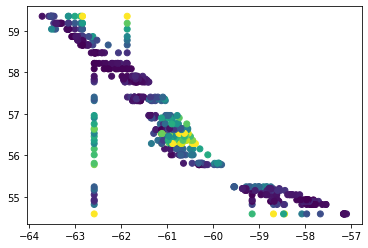

In [40]:
# Try interpolating on coastline

# Yred=[]
# Xred=[]
# for i in range(len(Y)):
#     inds = (np.where( (np.min(coasty) < np.min(Y[i]) ) & (coasty < np.max(Y[i])) & (coastx > -64)))
#     Yred.append(Y[i][inds])
#     Xred.append(X[i][inds])

d_km = []
for i in range(len(Xred)):
    # Interpolate sina
    f2 = interp1d(Yred[i],Xred[i],kind='nearest',fill_value="extrapolate")
    
    u_km, v_km = deg2km(coasty, f2(coasty) - coastx)
    d_km.append(u_km)
    plt.scatter(f2(coasty), coasty,c=d_km[i]) 

In [1197]:
np.shape(d_km)

(17, 32)

In [1193]:
xx,yy = np.meshgrid(years_sina,coasty)

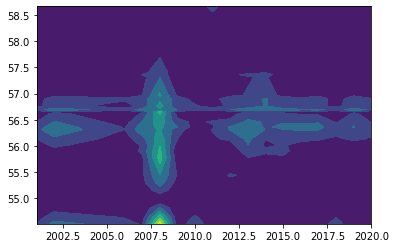

In [1201]:
plt.contourf(xx,yy,np.transpose(d_km))

In [1124]:
np.max(Yred[i])

58.66442237854

In [1135]:
np.min(coasty)

54.51334762573242